In [4]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from sqlalchemy import func
from sqlalchemy.dialects import postgresql

In [5]:
import numpy as np
import pandas as pd

In [6]:
import datetime as dt
from datetime import timedelta
from datetime import date

# Reflect Tables into SQLAlchemy ORM

In [9]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [10]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
inspector = inspect(engine)

In [11]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [12]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [13]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [14]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [15]:
inspector.get_table_names()

['measurement', 'station']

In [16]:
#Desc measurement
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [17]:
msmt_peek = session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).all()
#view syntax as SQL but remove .all() above else it will show the data
#print(msmt_peek)
msmt_peek_df = pd.DataFrame(msmt_peek)
msmt_peek_df.head(5)

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [18]:
 #Desc station
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [19]:
station_peek = session.query(Station.id, Station.station, Station.name, Station.latitude, Station.longitude,Station.elevation).all()
#view syntax as SQL but remove .all() above else it will show the data
#print(station_peek)
station_peek_df = pd.DataFrame(station_peek)
station_peek_df.head(5)

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


# Exploratory Climate Analysis

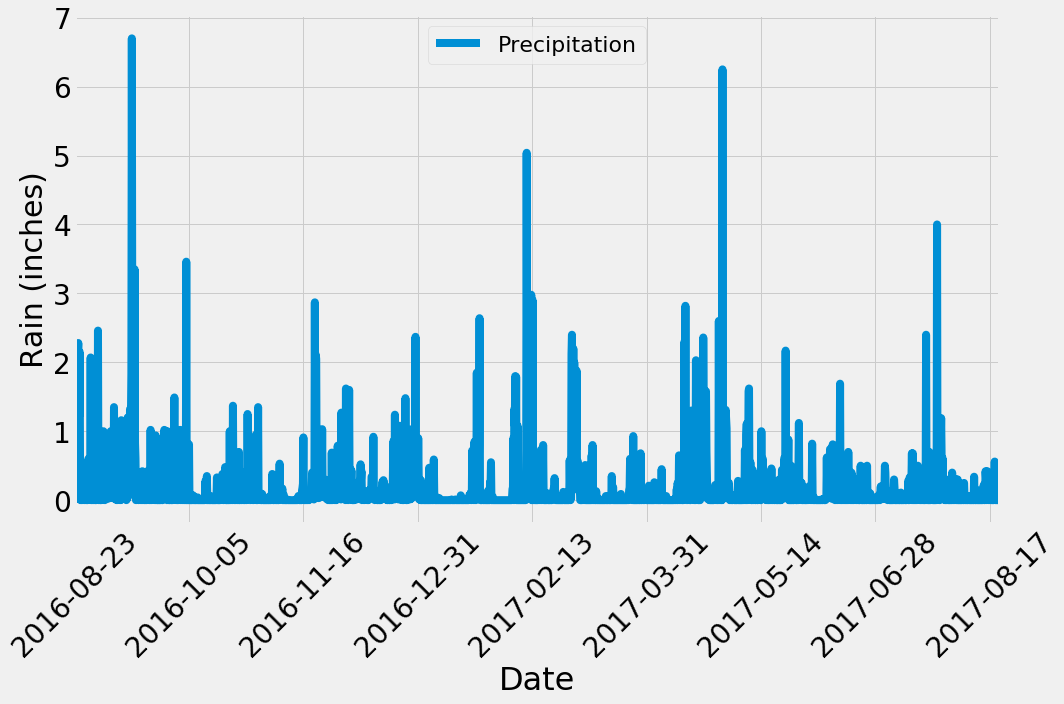

In [20]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#Max date 
max_date = session.query(func.max(Measurement.date)).first()
max_date_df = pd.to_datetime(max_date[0])

# Calculate the date 1 year ago from the last data point in the database

one_year_back = max_date_df - pd.Timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date
results = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date >= str(one_year_back)).all()
results_df = pd.DataFrame(results).sort_values("date",ascending=True).dropna()

# Use Pandas Plotting with Matplotlib to plot the data
results_df.plot('date', 'prcp', linewidth=8, figsize=(15,10), fontsize=28)
plt.xlabel("Date", fontsize=32)
plt.ylabel("Rain (inches)", fontsize=30)
plt.legend(["Precipitation"], loc="upper center", fontsize=22)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

![precipitation](Images/precipitation.png)

In [ ]:
# Use Pandas to calcualte the summary statistics for the precipitation data

In [21]:
results_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [27]:
# Design a query to show how many stations are available in this dataset?
def GetStations():
    results = session.query(Measurement.station).group_by(Measurement.station).count()
    print(f"{results} stations total.")
    
GetStations()   

9 stations total.


In [28]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station))\
.group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations 

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [29]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

def MostActiveStationStats():
    
    freq_station_stats = session.query(  func.min(Measurement.tobs).label('Lowest Temperature'),\
                                         func.max(Measurement.tobs).label('Highest Temperature'),\
                                         func.avg(Measurement.tobs).label('Average Temperature')\
                                       ).filter(Measurement.station =='USC00519281').all()
    print(freq_station_stats)

MostActiveStationStats()

[(54.0, 85.0, 71.66378066378067)]


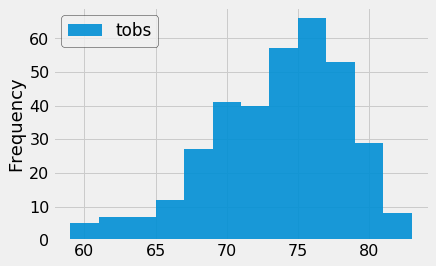

In [30]:
# Choose the station with the highest number of temperature observations.
most_tobs_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
most_tobs_station= most_tobs_station[0]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query( Measurement.tobs).filter(Measurement.date >= str(one_year_back)).filter(Measurement.station == most_tobs_station).all()
tobs_data_df = pd.DataFrame(tobs_data)

#Plot
x = tobs_data_df['tobs']
tobs_num_bins = 12
tobs_plot = plt.hist(x, tobs_num_bins, label='tobs', alpha=0.9)
 
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='y', labelsize=16)
plt.tick_params(axis='x', labelsize=16)
legend = plt.legend(frameon=True, edgecolor='black', fontsize='large')
plt.show()

![precipitation](Images/station-histogram.png)

In [31]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [32]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tobs_calc_temps = calc_temps('2012-02-28','2012-03-05')
tobs_calc_temps

[(62.0, 69.57142857142857, 74.0)]

In [33]:
tobs_calc_temps_df = pd.DataFrame(tobs_calc_temps, columns=["tmin","tavg","tmax"])
tobs_calc_temps_df

,tmin,tavg,tmax
0,62.0,69.571429,74.0


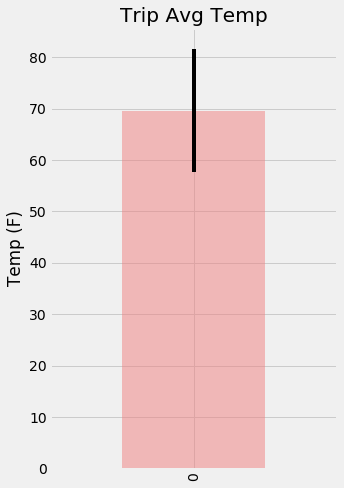

In [34]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tobs_calc_temps_df.plot.bar(y='tavg', yerr=(tobs_calc_temps_df['tmax'] - tobs_calc_temps_df['tmin']), title='Trip Avg Temp', color='lightcoral', alpha=0.5, figsize=(5,7))
plt.xticks = np.arange(len(tobs_calc_temps_df))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.show()


In [35]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
ws_rainfall = \
session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, Measurement.prcp).\
filter(Measurement.station == Station.station).\
filter(Measurement.date >= '2012-02-28').\
filter(Measurement.date <= '2012-03-05').\
group_by(Measurement.station).\
order_by(Measurement.prcp.desc()).all()

print(ws_rainfall)


[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.4), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.05), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.03), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, None)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


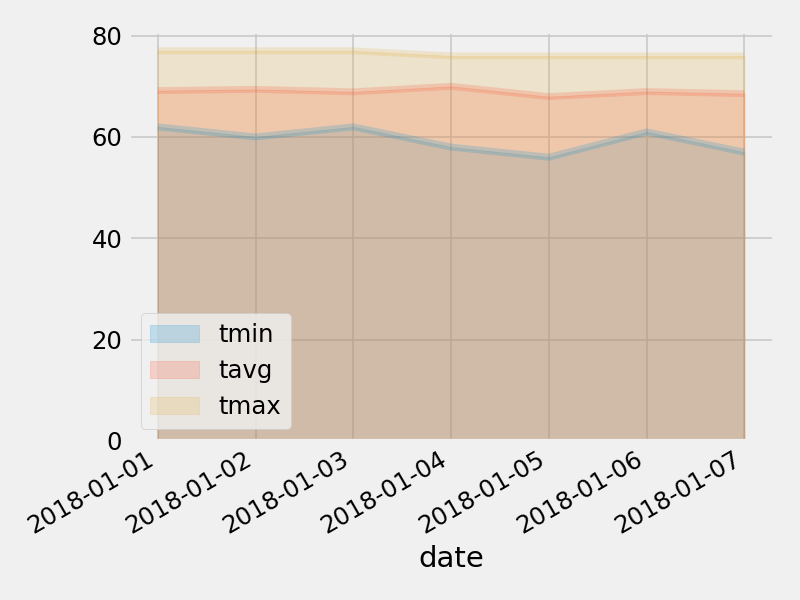

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
